In [163]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

import tensorflow as tf

# Image Input Shape:
image_input_shape = (224, 224, 3)
#pd.set_option('max_colwidth', None)

In [145]:
images_path = Path('../../../datasets/supervised/fish_data/Fish_Dataset/Fish_Dataset')
filepaths = list(images_path.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


In [146]:
filepaths_series = pd.Series(filepaths, name='Filepath').astype(str)
labels_series = pd.Series(labels, name='Label')

images_df = pd.concat([filepaths_series, labels_series], axis=1)

images_df = images_df[images_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [147]:
print(images_df.head())

                                                                                       Filepath  \
0  ../../../datasets/supervised/fish_data/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00481.png   
1  ../../../datasets/supervised/fish_data/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00495.png   
2  ../../../datasets/supervised/fish_data/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00324.png   
3  ../../../datasets/supervised/fish_data/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00442.png   
4  ../../../datasets/supervised/fish_data/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00456.png   

      Label  
0  Sea Bass  
1  Sea Bass  
2  Sea Bass  
3  Sea Bass  
4  Sea Bass  


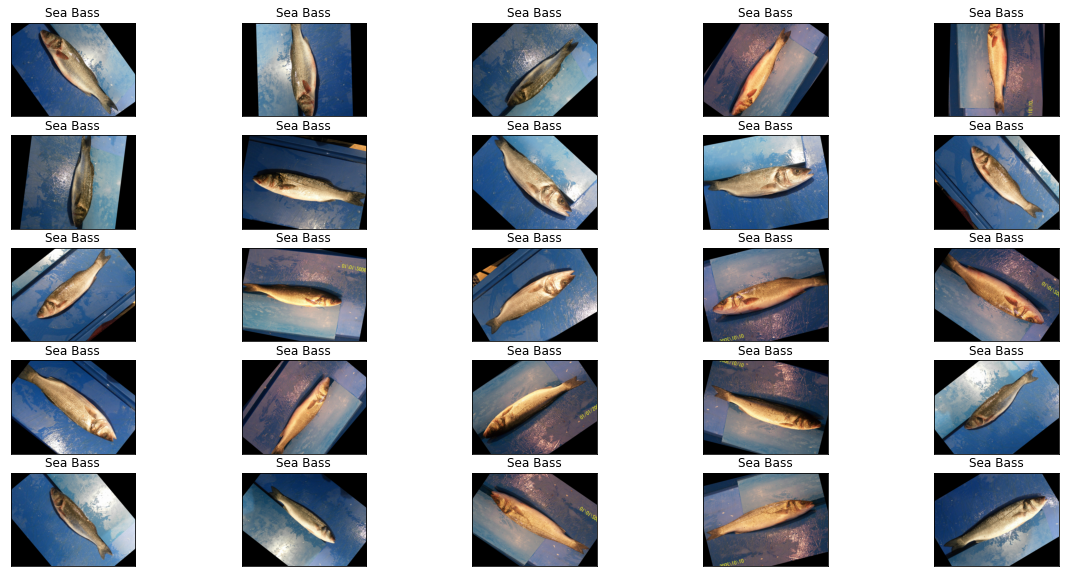

In [148]:
# Plotting of some images:
fix, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(images_df.Filepath[i]))
    ax.set_title(images_df.Label[i])

plt.show()

In [149]:
train_images, test_images = train_test_split(images_df, train_size=0.7, shuffle=True)

In [150]:
# Creating Image generator to manipulate images for better performance.
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input, 
    validation_split=0.2
    )

In [151]:
training_images = train_generator.flow_from_dataframe(
    dataframe=train_images,
    target_size=(224, 224),
    color_mode='rgb',
    x_col="Filepath",
    y_col="Label",
    class_mode='categorical',
    batch_size=50,
    shuffle=True,
    seed=27,
    subset='training'
)

Found 5040 validated image filenames belonging to 9 classes.


In [152]:
validation_images = train_generator.flow_from_dataframe(
    dataframe=train_images,
    target_size=(224, 224),
    color_mode='rgb',
    x_col="Filepath",
    y_col="Label",
    class_mode='categorical',
    batch_size=66,
    shuffle=True,
    seed=45,
    subset='validation'
)

Found 1260 validated image filenames belonging to 9 classes.


In [153]:
testing_images = train_generator.flow_from_dataframe(
    dataframe=test_images,
    target_size=(224, 224),
    color_mode='rgb',
    x_col="Filepath",
    y_col="Label", 
    class_mode='categorical',
    batch_size=30,
    shuffle=True,
    seed=62,
)

Found 2700 validated image filenames belonging to 9 classes.


In [154]:
def create_cnn_model():
    nn_components = [
        tf.keras.layers.Conv2D(20, (3,3), activation='elu', input_shape=image_input_shape ),
        tf.keras.layers.MaxPool2D(pool_size = (2,2)),
        tf.keras.layers.Conv2D(20, (3,3), activation='elu'),
        tf.keras.layers.MaxPool2D(pool_size = (2,2)),
        tf.keras.layers.Conv2D(80, (3,3), activation='elu'),
        tf.keras.layers.MaxPool2D(pool_size= (2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(250, activation='elu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(9, activation='softmax')
        ]
        
    model = tf.keras.models.Sequential(nn_components)
    model.summary()

    return model

In [155]:
cnn_model = create_cnn_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 222, 222, 20)      560       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 111, 111, 20)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 109, 109, 20)      3620      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 54, 54, 20)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 52, 52, 80)        14480     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 26, 26, 80)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 54080)            

In [156]:
# Compile how CNN will look to make predictions, optimise and measure loss:
cnn_optimizer_function = 'sgd' # 'sgd', 'adam', ''
cnn_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping condition once model is found:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

# Number of full iterations over the training dataset:
epochs = 10

# Training of the model
historical_training = cnn_model.fit(training_images, validation_data=validation_images, epochs=epochs, callbacks=early_stop_callback) 

Epoch 1/10
101/101 [==============================] - 111s 1s/step - loss: 1.4379 - accuracy: 0.4907 - val_loss: 0.9838 - val_accuracy: 0.6659
Epoch 2/10
101/101 [==============================] - 108s 1s/step - loss: 0.8482 - accuracy: 0.7069 - val_loss: 0.6981 - val_accuracy: 0.7333
Epoch 3/10
101/101 [==============================] - 98s 971ms/step - loss: 0.5538 - accuracy: 0.8135 - val_loss: 0.5583 - val_accuracy: 0.7976
Epoch 4/10
101/101 [==============================] - 117s 1s/step - loss: 0.3606 - accuracy: 0.8804 - val_loss: 0.3399 - val_accuracy: 0.8825
Epoch 5/10
101/101 [==============================] - 122s 1s/step - loss: 0.2372 - accuracy: 0.9300 - val_loss: 0.2787 - val_accuracy: 0.9143
Epoch 6/10
101/101 [==============================] - 120s 1s/step - loss: 0.1609 - accuracy: 0.9512 - val_loss: 0.2245 - val_accuracy: 0.9270
Epoch 7/10
101/101 [==============================] - 122s 1s/step - loss: 0.1045 - accuracy: 0.9726 - val_loss: 0.1734 - val_accuracy: 0.93

In [157]:
cnn_model.save('fish_cnn_model.h5')

In [175]:
# Inspecting the CNN model performance:
model_accuracy = historical_training.history['accuracy']
validation_accuracy = historical_training.history['val_accuracy']

model_loss = historical_training.history['loss']
validation_loss = historical_training.history['val_loss']

Text(0.5, 1.0, 'Training vs Validation Accuracy')

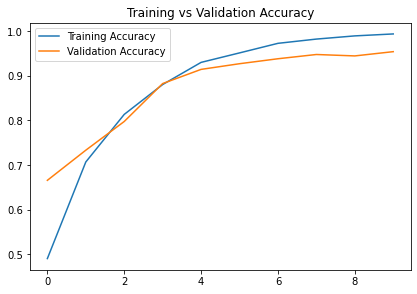

In [176]:
#Plotting results for Accuracy:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(model_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")


Text(0.5, 1.0, 'Training vs Validation Loss')

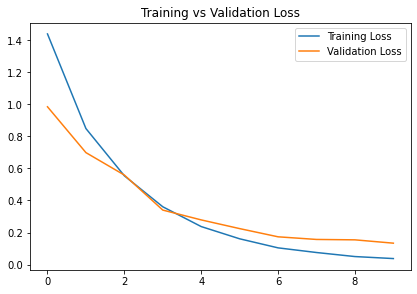

In [177]:
# Plotting results for loss:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(model_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend()
plt.title("Training vs Validation Loss")

In [178]:
# Make some predictions:
predictions = cnn_model.predict(testing_images)
predictions = np.argmax(predictions, axis=1)


In [182]:
labels = testing_images.class_indices
labels = dict((v,k) for k, v in labels.items())

y_predictions = [labels[k] for k in predictions]

In [186]:
print(classification_report(test_images.Label, y_predictions))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.10      0.10      0.10       304
   Gilt-Head Bream       0.10      0.10      0.10       292
   Hourse Mackerel       0.11      0.12      0.11       306
        Red Mullet       0.13      0.12      0.12       274
     Red Sea Bream       0.13      0.13      0.13       330
          Sea Bass       0.08      0.08      0.08       276
            Shrimp       0.09      0.10      0.10       293
Striped Red Mullet       0.11      0.11      0.11       297
             Trout       0.12      0.11      0.11       328

          accuracy                           0.11      2700
         macro avg       0.11      0.11      0.11      2700
      weighted avg       0.11      0.11      0.11      2700



In [187]:
cnn_model.evaluate(testing_images)[1]

90/90 [==============================] - 34s 376ms/step - loss: 0.1291 - accuracy: 0.9552


0.9551851749420166

In [ ]:
"""Conclusions: The model needs to be refined, but does provide somewhat good results. 
The classification report also needs to be investigated further, 
as when evaluating the model using test results show a higher percentage in prediction accuracy."""